## Section1 Part2 Pipeline Evaluation (Accuracy & Robustness) for Long Read Data
#### Ke Liu

In [1]:
import os
import subprocess as sp
import pandas as pd
import numpy as np
import math
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
import pysam as ps
import time
import matplotlib.font_manager as font_manager
from tqdm import tqdm
from scipy.spatial.distance import jensenshannon
font_manager.fontManager.addfont('/home/qukun/liuke/miniconda3/fonts/Arial.ttf')
mpl.rcParams["font.sans-serif"] = "Arial"
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.serif'] = ['Arial']

### Step1 Transform the eccDNA result into uniform format 

In [ ]:
reference = '/home/qukun/liuke/reference/ucsc/hg38/hg38.fa'
def get_seq(chrom, start, end, genome_fasta = reference):
    # Function to call samtools to get sequence information
    fa = ps.Fastafile(genome_fasta)
    seq = fa.fetch(chrom, int(start), int(end))
    seq = seq.upper()
    return seq
def write_fasta(df, fasta):
    with open(fasta,'w') as f:
        for i in df.index:
            f.write('>{0}\n'.format(df.loc[i,'ecID']))
            f.write(df.loc[i,'seq'])
            f.write('\n')
        f.close()

In [ ]:
def chimeric2bed(dataset_chimeric):
    dataset_chim = pd.DataFrame(columns=['Chromosome','Start','End','Length','ecID'])
    k=0
    for i in dataset_chimeric.index:
        for j in range(int(dataset_chimeric.shape[1]/4)):
            if not (dataset_chimeric.loc[i,4*j].startswith('chr')):
                break
            dataset_chim.loc[k] =  [dataset_chimeric.loc[i,4*j], dataset_chimeric.loc[i,4*j+1], dataset_chimeric.loc[i,4*j+2], dataset_chimeric.loc[i,4*j+3], 'chim'+str(i+1)]
            k+=1
    dataset_chim = dataset_chim[~dataset_chim.ecID.isin(dataset_chim[dataset_chim.Chromosome=='chrM'].ecID)]
    return dataset_chim

In [ ]:
def split2region(region):
    temp = region.split(',')
    region_table = pd.DataFrame(columns=['Chromosome','Start','End','Length','Strand'])
    for i in range(len(temp)):
        chrom = temp[i].split(':')[0]
        ss = temp[i].split(':')[1].split('-')
        start = ss[0]
        end = ss[1].split('_')[0]
        strand = ss[1].split('_')[1]
        length = int(end)-int(start)+1
        region_table.loc[i] = [chrom,start,end,length,strand]
    return region_table

def result2bed(result,coverage=False):
    bed_merge = pd.DataFrame(columns=['Chromosome','Start','End','Length','ecID','Strand','Reads','Coverage'])
    for i in result.index:
        region_table = split2region(result.loc[i,'merge_region'])
        region_table.insert(region_table.shape[1],'Reads',result.loc[i,'numreads'])
        region_table.insert(region_table.shape[1],'Coverage',result.loc[i,'coverage'])
        region_table.insert(4,'ecID',result.loc[i,'id'])
        bed_merge = pd.concat([bed_merge,region_table],axis=0)
    bed_merge = bed_merge.reset_index()
    bed_merge = bed_merge.drop('index',axis=1)
    bed_merge.loc[bed_merge[bed_merge.Strand==''].index,'Strand']='-'
    simple_bed = bed_merge[bed_merge.ecID.isin(result[result.num_region==1].id)]
    chimeric_bed = bed_merge[bed_merge.ecID.isin(result[result.num_region>1].id)]
    return  simple_bed, chimeric_bed

In [ ]:
Nanopore_sim = ['dataset{0}.{1}'.format(a,b) for a in list(range(4,7)) +[8] for b in ['05','10','15','20','25','30','35','40','45','50','20.00', '20.10', '20.20', '20.30', '20.40', '20.50']]

#### 0.1 CReSIL

In [ ]:
output_fasta_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/filtered/fasta/'
output_bed_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/filtered/bed/'
for sample in tqdm(Nanopore_sim):
    ## Read the raw result 
    temp_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/raw/'+sample+'.cresil.bed'
    if os.path.exists(temp_path): 
        temp_result = pd.read_csv(temp_path, sep='\t')
        ## Filter the result with length    
        temp_result = temp_result[(temp_result['eccdna_status']=='cyclic')&
                                  (temp_result['merge_len']<1e7)
                                 ]
        temp_bed = result2bed(temp_result)
        if (len(temp_bed[0])!=0):
            temp_simple = temp_bed[0][['Chromosome', 'Start', 'End', 'ecID', 'Reads', 'Coverage', 'Length']]
            locals()[sample+'_cresil_simple'] = temp_simple
            locals()[sample+'_cresil_simple'].to_csv(output_bed_path +sample+'.cresil_simple.filtered.bed',index=None,header=None,sep='\t')
            temp_simple.insert(6,'seq',temp_simple.apply(lambda x: get_seq(x[0],x[1],x[2]), axis=1))
            write_fasta(temp_simple, output_fasta_path + sample + '.cresil_simple.fasta')
        if (len(temp_bed[1])!=0):
            temp_chimeric = temp_bed[1][['Chromosome', 'Start', 'End', 'ecID', 'Reads', 'Coverage', 'Length']]
            locals()[sample+'_cresil_complex'] = temp_chimeric
            locals()[sample+'_cresil_complex'].to_csv(output_bed_path +sample+'.cresil_complex.filtered.bed',index=None,header=None,sep='\t')
            temp_chimeric.insert(6,'seq',temp_chimeric.apply(lambda x: get_seq(x[0],x[1],x[2]), axis=1))
            temp_chimeric_fasta = temp_chimeric.groupby('ecID')['seq'].apply(lambda x: x.str.cat(sep='')).reset_index()
            write_fasta(temp_chimeric_fasta, output_fasta_path + sample + '.cresil_complex.fasta')  

#### 0.2 NanoCircle

In [ ]:
output_fasta_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/filtered/fasta/'
output_bed_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/filtered/bed/'
for sample in tqdm(Nanopore_sim):
    temp_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/raw/'+sample+'.nanocircle_simple.bed'
    if os.path.exists(temp_path): 
        temp_result = pd.read_csv(temp_path, sep='\t',names=['Chromosome','Start','End','Length','Reads','Status','ecID'])
        temp_result = temp_result[(temp_result.Status=='high_conf')&(temp_result.Length<1e7)]
        temp_result.insert(5,'Coverage', 0)
        temp_result.insert(7,'seq',temp_result.apply(lambda x: get_seq(x[0],x[1],x[2]), axis=1))
        write_fasta(temp_result, output_fasta_path + sample + '.nanocircle_simple.fasta')
        locals()[sample+'_nanocircle_simple'] = temp_result[['Chromosome', 'Start', 'End', 'ecID', 'Reads', 'Coverage', 'Length']]
        locals()[sample+'_nanocircle_simple'].to_csv(output_bed_path +sample+'.nanocircle_simple.filtered.bed',index=None,header=None,sep='\t')

In [ ]:
output_fasta_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/filtered/fasta/'
output_bed_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/filtered/bed/'
for sample in tqdm(Nanopore_sim):
    temp_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/raw/'+sample+'.nanocircle_complex.bed'
    if os.path.exists(temp_path): 
        temp_result = pd.read_csv(temp_path, sep='\t',header=None)
        temp_bed = chimeric2bed(temp_result)
        temp_bed.insert(4,'Reads', 0)
        temp_bed.insert(5,'Coverage', 0)
        temp_bed.insert(7,'seq',temp_bed.apply(lambda x: get_seq(x[0],x[1],x[2]), axis=1))
        temp_fasta = temp_bed.groupby('ecID')['seq'].apply(lambda x: x.str.cat(sep='')).reset_index()
        locals()[sample+'_nanocircle_complex'] = temp_bed[['Chromosome', 'Start', 'End', 'ecID', 'Reads', 'Coverage', 'Length']]
        write_fasta(temp_fasta, output_fasta_path + sample + '.nanocircle_complex.fasta')
        locals()[sample+'_nanocircle_complex'].to_csv(output_bed_path +sample+'.nanocircle_complex.filtered.bed',index=None,header=None,sep='\t')

#### 0.3 ecc_finder(map-sr)

In [ ]:
output_fasta_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/filtered/fasta/'
output_bed_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/filtered/bed/'
ecc_finder_columns = ['Chromosome','Start','End','Reads','Repeats','Repeats2','Length']
for sample in tqdm(Nanopore_sim):
    ## Read the raw result 
    temp_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/raw/'+sample+'.ecc_finder_map.bed'
    if os.path.exists(temp_path): 
        temp_result = pd.read_csv(temp_path, delimiter='\t', names=ecc_finder_columns)
        ## Add Information
        temp_result.insert(3, 'ecID', ['ec{0}'.format(num) for num in range(1,len(temp_result)+1)])
        temp_result.insert(5, 'Coverage', 0)
        ## Filter the result with length
        temp_result = temp_result[temp_result["Length"]<1e7]
        ## Get the eccDNA sequence and write it into fasta
        temp_result.insert(6,'seq',temp_result.apply(lambda x: get_seq(x[0],x[1],x[2]), axis=1))
        write_fasta(temp_result, output_fasta_path+sample+'.ecc_finder_map.fasta')
        locals()[sample+'_ecc_finder_map'] = temp_result[['Chromosome', 'Start', 'End', 'ecID', 'Reads', 'Coverage', 'Length']]
        locals()[sample+'_ecc_finder_map'].to_csv(output_bed_path + sample + '.ecc_finder_map.filtered.bed', sep='\t', header=None, index=None)

### Step2 Run Mummer3

###### For each pipe line we change the `tool` parameter  

### Step3 Calculate the Statistics 

#### 3.0 Parameters and function to merge intervals 

In [2]:
dataset_list = ['dataset1','dataset2','dataset3','dataset4','dataset5','dataset6','dataset7']
prop_dict = {'20.00':0,'20.10':10,'20.20':20,'20.30':30,'20.40':40,'20.50':50}
depth_dict = {'05':5,'10':10,'15':15,'20':20,'25':25,'30':30,'35':35,'40':40,'45':45,'50':50}
palette_nanopore = {'cresil': '#9146ff', 
                    'ecc_finder_map': '#e66760', 
                    'eccDNA_RCA_nanopore':'#1da1f2', 
                    'nanocircle': '#99cc33',
                    'ecc_finder_asm': '#FFB7B7'
                   }
nanopore_tools = ['ecc_finder_map', 'ecc_finder_asm', 'eccDNA_RCA_nanopore', 'nanocircle','cresil']
nanopore_labels = {'cresil':'CReSIL', 
                   'ecc_finder_map':'ecc_finder(map-ont)', 
                   'eccDNA_RCA_nanopore':'eccDNA_RCA_nanopore', 
                   'nanocircle':'NanoCircle',
                   'ecc_finder_asm':'ecc_finder(asm-ont)'}
cond_dict = {'p':'pos', 'n':'neg'}

In [ ]:
def merge(intervals):
    # Sort the intervals by the start position (optional, but not necessary)
    # intervals.sort(key=lambda x: x[0])
    merged = []
    for interval in sorted(intervals, key=lambda x: x[0]):
        if not merged or merged[-1][-1] < interval[0]:
            merged.append(interval)
        else:
            merged[-1][-1] = max(merged[-1][-1], interval[-1])
    return merged

#### 3.1 Filtered the sequence with identity and distance over the threshhold

In [ ]:
for threshhold in [90,95,98,99]:
    print('Threshhold:{0}'.format(threshhold))
    for tool in nanopore_tools:
        for data in tqdm(dataset_list,desc=tool,position=0):
            result_table=pd.DataFrame(columns=['prop','Tools','TP1','TP2','FP','TN','FN','Sensitivity','Specificity','F1score','PCC','RMSE','JSD'])
            for sample in tqdm({**prop_dict,**depth_dict},position=0,leave=False,desc=tool+data):
                pos_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/mummer/'+data+'.'+sample+'.'+tool+'.pos.mcoords'
                neg_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/mummer/'+data+'.'+sample+'.'+tool+'.neg.mcoords'
                fasta_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/filtered/fasta/'+data+'.'+sample+'.'+tool+'.fasta'
                if os.path.exists(fasta_path):
                    if (os.path.getsize(pos_path)!=0):
                        for cond in cond_dict:
                            ## Select the rows pass the threshhold
                            locals()[data+'_'+sample+'_'+tool+'_'+cond_dict[cond]] = temp = pd.read_csv(locals()[cond_dict[cond]+'_path'],sep='\t',header=None,index_col=None)
                            locals()[data+'_'+sample+'_'+tool+'_'+cond_dict[cond]+'_select'] = temp[(temp[6]>threshhold)]
                            ##        
                            locals()[data+'_'+sample+'_'+tool+'_'+cond_dict[cond]+'_merge'] = pd.DataFrame(columns=range(13))
                            ##
                            simple_temp = locals()[data+'_'+sample+'_'+tool+'_'+cond_dict[cond]+'_select']
                            simple_temp = simple_temp[simple_temp[11].str.contains('s'+cond)]
                            ##
                            chimeric_temp = locals()[data+'_'+sample+'_'+tool+'_'+cond_dict[cond]+'_select']
                            chimeric_temp = chimeric_temp[chimeric_temp[11].str.contains('c'+cond)]
                            chimeric_temp.insert(13,13,chimeric_temp[11].astype(str)+chimeric_temp[12].astype(str))
                            for i in chimeric_temp[13].unique():
                                merge_temp = chimeric_temp[chimeric_temp[13]==i]
                                length_a = list(merge_temp[7])[0];length_b = list(merge_temp[8])[0]
                                id_a = list(merge_temp[11])[0];id_b = list(merge_temp[12])[0]
                                se1 = []; se2 = []
                                for j in merge_temp.index:
                                    if (merge_temp.loc[j,0]<merge_temp.loc[j,1]): se1.append([merge_temp.loc[j,0],merge_temp.loc[j,1]])
                                    else: se1.append([merge_temp.loc[j,1],merge_temp.loc[j,0]])
                                    if (merge_temp.loc[j,2]<merge_temp.loc[j,3]):se2.append([merge_temp.loc[j,2],merge_temp.loc[j,3]])
                                    else: se2.append([merge_temp.loc[j,3],merge_temp.loc[j,2]])
                                intersect_a = abs(pd.DataFrame(merge(se1))[1].sum()-pd.DataFrame(merge(se1))[0].sum())
                                intersect_b = abs(pd.DataFrame(merge(se2))[1].sum()-pd.DataFrame(merge(se2))[0].sum())
                                locals()[data+'_'+sample+'_'+tool+'_'+cond_dict[cond]+'_merge'].loc[i] = [0,0,0,0,intersect_a,intersect_b,0,length_a,length_b,intersect_a*100/length_a,intersect_b*100/length_b,id_a,id_b]
                            locals()[data+'_'+sample+'_'+tool+'_'+cond_dict[cond]+'_merge'+str(threshhold)] = merge_data = pd.concat([locals()[data+'_'+sample+'_'+tool+'_'+cond_dict[cond]+'_merge'], simple_temp])
                            locals()[data+'_'+sample+'_'+tool+'_'+cond_dict[cond]+'_merge_'+str(threshhold)+'select'] = merge_data[(merge_data[9]>threshhold)&
                                                                                                                                   (merge_data[10]>threshhold)&
                                                                                                                                   (merge_data[7]+merge_data[8]-merge_data[4]-merge_data[5]<500)]
                            locals()[data+'_'+sample+'_'+tool+'_'+cond_dict[cond]+'_merge'+str(threshhold)].to_csv('/home/qukun/liuke/workspace/benchmark/result/sim3rd/mummer_%i/'%threshhold+data+'.'+sample+'.'+tool+'.'+cond_dict[cond]+'.%imcoords'%threshhold,sep='\t',header=None,index=None)
                            locals()[data+'_'+sample+'_'+tool+'_'+cond_dict[cond]+'_merge_'+str(threshhold)+'select'].to_csv('/home/qukun/liuke/workspace/benchmark/result/sim3rd/mummer_%i/'%threshhold+data+'.'+sample+'.'+tool+'.'+cond_dict[cond]+'.select.%imcoords'%threshhold,sep='\t',header=None,index=None)

#### 3.2 Reload the filtered mummer results, add filter of base resolution and test the influence of different threshhold 

In [3]:
for threshhold in [90,95,98,99]:
    print('Threshhold:{0}'.format(threshhold))
    for tool in nanopore_tools:
        for data in tqdm(dataset_list,desc=tool,position=0):
            result_table=pd.DataFrame(columns=['prop','Tools','TP1','TP2','FP','TN','FN','Sensitivity','Specificity','F1score','PCC','RMSE','JSD'])
            for sample in tqdm({**prop_dict,**depth_dict},position=0,leave=False,desc=tool+data):
                pos_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/mummer/'+data+'.'+sample+'.'+tool+'.pos.mcoords'
                neg_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/mummer/'+data+'.'+sample+'.'+tool+'.neg.mcoords'
                fasta_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/filtered/fasta/'+data+'.'+sample+'.'+tool+'.fasta'
                if os.path.exists(fasta_path):
                    if (os.path.getsize(pos_path)!=0):
                        for cond in cond_dict:
                            locals()[data+'_'+sample+'_'+tool+'_'+cond_dict[cond]+'_merge'+str(threshhold)] = merge_data = pd.read_csv('/home/qukun/liuke/workspace/benchmark/result/sim3rd/mummer_%i/'%threshhold+data+'.'+sample+'.'+tool+'.'+cond_dict[cond]+'.%imcoords'%threshhold,
                                                                                                                                       sep='\t',
                                                                                                                                       header=None,
                                                                                                                                       index_col=None)
                            locals()[data+'_'+sample+'_'+tool+'_'+cond_dict[cond]+'_merge_'+str(threshhold)+'select'] = merge_data[(merge_data[9]>threshhold)&
                                                                                                                                    (merge_data[10]>threshhold)&
                                                                                                                                    (merge_data[7]+merge_data[8]-merge_data[4]-merge_data[5]<500)]

Threshhold:90


cresil: 100%|██████████| 7/7 [00:09<00:00,  1.40s/it]          


Threshhold:95


cresil: 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]          


Threshhold:98


cresil: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]          


Threshhold:99


cresil: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]          


cresil: 100%|██████████| 7/7 [00:00<00:00, 13.00it/s]


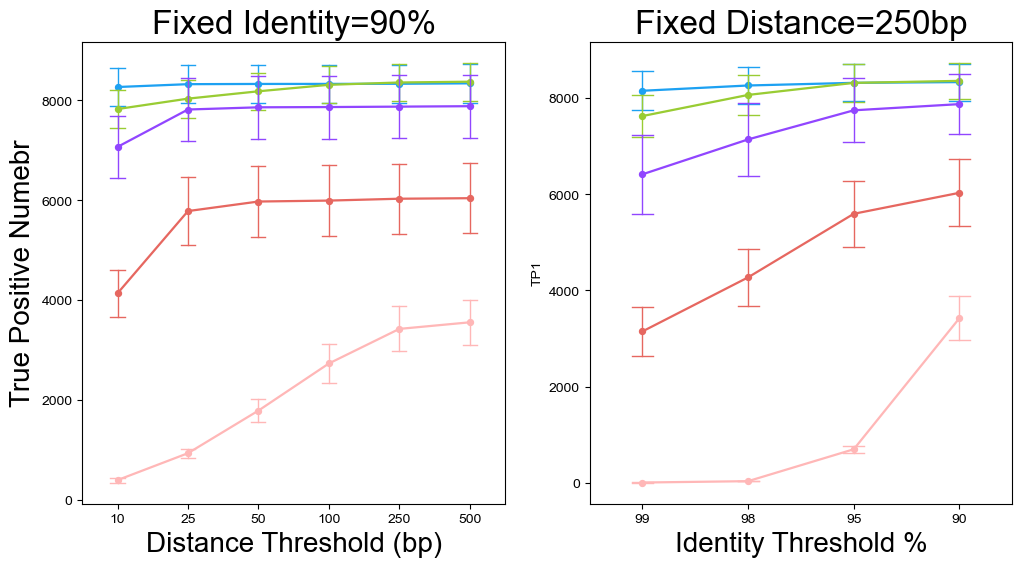

In [4]:
table_fixed_distance = pd.DataFrame(columns=['dataset','Tools','99','98','95','90'])
table_fixed_identity = pd.DataFrame(columns=['dataset','Tools','500','250','100','50','25','10'])

##
for tool in nanopore_tools:
    for data in tqdm(dataset_list,desc=tool):
        rows_distance = [data, tool]
        rows_identity = [data, tool]
        ## init 
        pos_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/mummer/'+data+'.50.'+tool+'.pos.mcoords'
        neg_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/mummer/'+data+'.50.'+tool+'.neg.mcoords'
        fasta_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/filtered/fasta/'+data+'.50.'+tool+'.fasta'
        if os.path.exists(fasta_path):
            if (os.path.getsize(pos_path)!=0)&((os.path.getsize(neg_path)!=0)):
                for threshhold in [99,98,95,90]:
                    temp_select = locals()[data+'_50_'+tool+'_pos_merge_'+str(threshhold)+'select']
                    temp_select = temp_select[(temp_select[7]+temp_select[8]-temp_select[4]-temp_select[5]<250)]
                    rows_distance += [len(temp_select[11].unique())]
                for dist in [500,250,100,50,25,10]:
                    temp_select = locals()[data+'_50_'+tool+'_pos_merge_90select']
                    temp_select = temp_select[(temp_select[7]+temp_select[8]-temp_select[4]-temp_select[5]<dist)]
                    rows_identity += [len(temp_select[11].unique())]
                table_fixed_distance  = pd.concat([table_fixed_distance,pd.DataFrame(rows_distance,index=table_fixed_distance.columns).T],axis=0)
                table_fixed_identity  = pd.concat([table_fixed_identity,pd.DataFrame(rows_identity,index=table_fixed_identity.columns).T],axis=0)

plot_distance = table_fixed_distance.melt(id_vars=['dataset', 'Tools'], var_name='Identity', value_name='TP1')
plot_identity = table_fixed_identity.melt(id_vars=['dataset', 'Tools'], var_name='Distance', value_name='TP1')

## Visualization
fig = plt.figure(figsize=(12,6))
subplot = gs.GridSpec(1, 2, width_ratios=[1, 1],hspace=0.3, wspace=0.2)
ax1 = fig.add_subplot(subplot[0, 0])
ax2 = fig.add_subplot(subplot[0, 1])

sns.pointplot(data=plot_identity, 
              x='Distance', 
              y='TP1', 
              hue='Tools',
              palette=palette_nanopore,
              hue_order=nanopore_tools,
              scale=0.6,
              errwidth=1,
              capsize=0.2,
              errorbar='se',
              ax=ax1)
sns.pointplot(data=plot_distance, 
              x='Identity', 
              y='TP1', 
              hue='Tools',
              palette=palette_nanopore,
              hue_order=nanopore_tools,
              scale=0.6,
              errwidth=1,
              capsize=0.2,
              errorbar='se',
              ax=ax2)

ax1.invert_xaxis()
ax1.legend_.remove();ax2.legend_.remove()
ax1.set_title('Fixed Identity=90%',fontsize=24); ax2.set_title('Fixed Distance=250bp',fontsize=24)
ax1.set_xlabel('Distance Threshold (bp)',fontsize=20); ax2.set_xlabel('Identity Threshold %',fontsize=20)
ax1.set_ylabel('True Positive Numebr',fontsize=20); ax1.set_ylabel('True Positive Numebr',fontsize=20)

## Save
plt.savefig('/home/qukun/liuke/workspace/benchmark/Figure/R2C7_LR.pdf', dpi=2000, bbox_inches='tight')
plot_distance.to_csv('/home/qukun/liuke/workspace/benchmark/Figure/R2C7_LR_fixed_distance.csv',sep='\t')
plot_identity.to_csv('/home/qukun/liuke/workspace/benchmark/Figure/R2C7_LR_fixed_identity.csv',sep='\t')

#### 3.3 Using Identity=90% and Distance=250bp to calculate the statistics for benchmarking

In [5]:
for threshhold in [90]:
    print('Threshhold:{0}'.format(threshhold))
    locals()['total_depth_result'+str(threshhold)] = pd.DataFrame()
    locals()['total_prop_result'+str(threshhold)] = pd.DataFrame()
    for tool in nanopore_tools:
        for data in tqdm(dataset_list,desc=tool):
            depth_table=pd.DataFrame(columns=['dataset','sample','tools','TP1','TP2','FP','TN','FN','Specificity','Recall','Recall_Simple','Recall_Chimeric','Precision1','Precision2','F1score1','F1score2','Distance','Redundancy'])
            prop_table=pd.DataFrame(columns=['dataset','sample','tools','TP1','TP2','FP','TN','FN','Specificity','Recall','Recall_Simple','Recall_Chimeric','Precision1','Precision2','F1score1','F1score2','Distance','Redundancy'])
            for sample in tqdm({**prop_dict,**depth_dict},position=0,leave=False,desc=tool+data):
                pos_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/mummer/'+data+'.'+sample+'.'+tool+'.pos.mcoords'
                neg_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/mummer/'+data+'.'+sample+'.'+tool+'.neg.mcoords'
                fasta_path = '/home/qukun/liuke/workspace/benchmark/result/sim3rd/filtered/fasta/'+data+'.'+sample+'.'+tool+'.fasta'
                if os.path.exists(fasta_path):
                    if (os.path.getsize(pos_path)!=0)&((os.path.getsize(neg_path)!=0)):
                        if '.' in sample:
                            template_bed = '/home/qukun/liuke/workspace/benchmark/data/sim/'+data+'/'+data+'.'+sample+'/'+data+'.'+sample+'.pos.bed'
                        else:
                            template_bed = '/home/qukun/liuke/workspace/benchmark/data/sim/'+data+'/'+data+'.50/'+data+'.50.pos.bed'
                        # Counts of identified eccDNA
                        count = len(open(fasta_path,'r').readlines())/2
                        
                        # Calculate True Positive 
                        pos_select = locals()[data+'_'+sample+'_'+tool+'_pos_merge_'+str(threshhold)+'select']
                        neg_select = locals()[data+'_'+sample+'_'+tool+'_neg_merge_'+str(threshhold)+'select']
                        
                        pos_select = pos_select[pos_select[7]+pos_select[8]-pos_select[4]-pos_select[5]<250]
                        neg_select = neg_select[neg_select[7]+neg_select[8]-neg_select[4]-neg_select[5]<250]
                        
                        
                        TP2 = len(pos_select[12].unique())
                        
                        TP_simple = sum('sp' in i for i in pos_select[11].unique()) 
                        TP_chimeric = sum('cp' in i for i in pos_select[11].unique())
                        Distance = (pos_select[7] + pos_select[8] - pos_select[4] - pos_select[5]).mean()                    
                        
                        ### filter fragments < 200bp
                        template = pd.read_csv(template_bed,sep='\t',header=None)
                        small_id = template[template[3]<200][4].unique() 
                        simulate_total = 10000 - len(small_id)
                        simulate_simple = sum('sp' in i for i in template[4].unique()) - sum('sp' in i for i in small_id)
                        simulate_chimeric = sum('cp' in i for i in template[4].unique()) - sum('cp' in i for i in small_id)
                        
                        pos_select = pos_select[~pos_select[11].isin(small_id)]
                        TP1 = len(pos_select[11].unique())
                        
                        Redundancy = len(pos_select[12].unique())/ len(pos_select[11].unique())
                        FP = count - TP2
                        FN = simulate_total - TP1
                        TN = 10000 - len(neg_select[11].unique())
                        Specificity = TN/(TN+FP)
                        Recall_simple = TP_simple/simulate_simple
                        
                        if simulate_chimeric!=0:
                            Recall_chimeric = TP_chimeric/simulate_chimeric
                        else:
                            Recall_chimeric = None
                        if (TP1!=0):
                            Recall = TP1/simulate_total
                            Precision1 = TP1/(TP1+FP)
                            Precision2 = TP2/(TP2+FP)
                            F1score1 = 2 * Precision1 * Recall / (Precision1 + Recall)
                            F1score2 = 2 * Precision2 * Recall / (Precision2 + Recall)
                        else:
                            Recall = Precision = F1score = 0
                        if '.' in sample:
                            prop_table.loc[prop_dict[sample]]=[data,prop_dict[sample],tool,TP1,TP2,FP,TN,FN,Specificity,Recall,Recall_simple,Recall_chimeric,Precision1,Precision2,F1score1,F1score2,Distance,Redundancy]
                        else:
                            depth_table.loc[depth_dict[sample]]=[data,depth_dict[sample],tool,TP1,TP2,FP,TN,FN,Specificity,Recall,Recall_simple,Recall_chimeric,Precision1,Precision2,F1score1,F1score2,Distance,Redundancy]
            locals()['total_depth_result'+str(threshhold)]=pd.concat([locals()['total_depth_result'+str(threshhold)],depth_table])
            locals()['total_prop_result'+str(threshhold)]=pd.concat([locals()['total_prop_result'+str(threshhold)],prop_table])
total_depth_result90.to_csv('/home/qukun/liuke/workspace/benchmark/Figure/Total_LR_Depth_result.csv',sep='\t')
total_prop_result90.to_csv('/home/qukun/liuke/workspace/benchmark/Figure/Total_LR_Proportion_result.csv',sep='\t')

Threshhold:90


cresil: 100%|██████████| 7/7 [00:23<00:00,  3.39s/it]          


##### 3.3.1 Visualise performance of datasets Depth=50

In [6]:
plot_Distance_F1score = pd.DataFrame(columns = ['tools','sample_number','meanDistance','meanF1score','stdDistance','stdF1score','seDistance','seF1score'])
i=0
for tool in nanopore_tools:
    temp = locals()['total_depth_result'+str(threshhold)][(locals()['total_depth_result'+str(threshhold)]['tools']==tool)&
                                                           (locals()['total_depth_result'+str(threshhold)]['sample']==50)]
    plot_Distance_F1score.loc[i] = [tool,len(temp),temp.Distance.mean(),temp.F1score2.mean(),temp.Distance.std(),temp.F1score2.std(),temp.Distance.std()/math.sqrt(len(temp)),temp.F1score2.std()/math.sqrt(len(temp))]
    i+=1

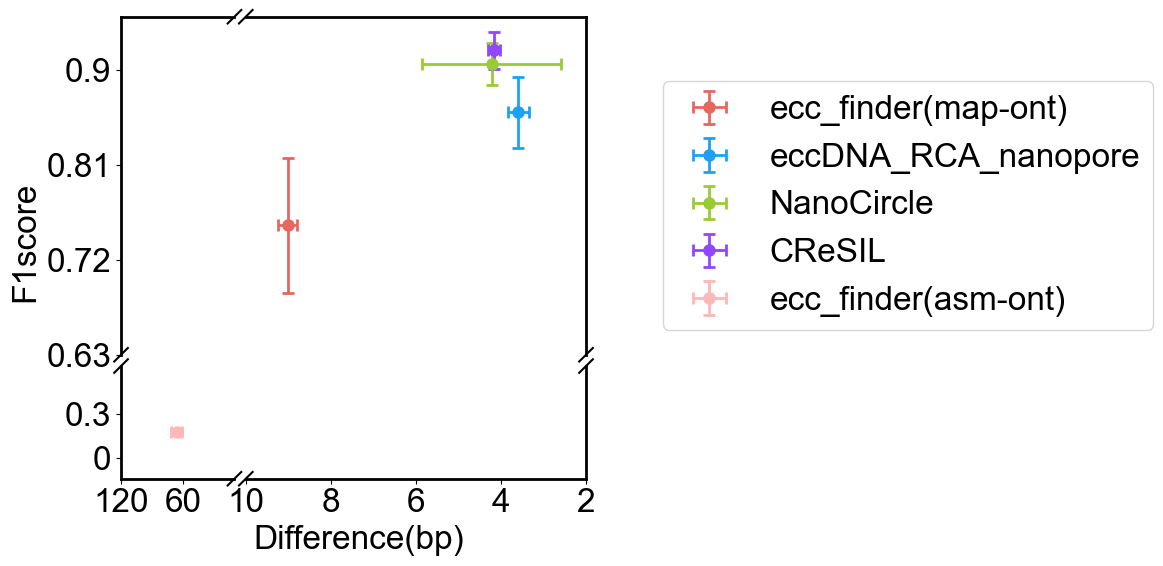

In [7]:
fig = plt.figure(figsize=(6,6))
subplot = gs.GridSpec(2, 2, height_ratios=[3,1], width_ratios=[1, 3],hspace=0.05, wspace=0.05)
ax1 = fig.add_subplot(subplot[0, 0])
ax2 = fig.add_subplot(subplot[0, 1])
ax3 = fig.add_subplot(subplot[1, 0])
ax4 = fig.add_subplot(subplot[1, 1])
for tool in nanopore_tools:
    if (tool == 'ecc_finder_asm'):
        ax3.errorbar(x=plot_Distance_F1score[plot_Distance_F1score.tools==tool].meanDistance,
                     y=plot_Distance_F1score[plot_Distance_F1score.tools==tool].meanF1score, 
                     xerr=plot_Distance_F1score[plot_Distance_F1score.tools==tool].seDistance, 
                     yerr=plot_Distance_F1score[plot_Distance_F1score.tools==tool].seF1score, 
                     fmt='o', 
                     elinewidth=2,
                     markersize=8,
                     capsize=4,
                     capthick=2,
                     color=palette_nanopore[tool],
                     label=nanopore_labels[tool],
                   )
    else:
        ax2.errorbar(x=plot_Distance_F1score[plot_Distance_F1score.tools==tool].meanDistance, 
                     y=plot_Distance_F1score[plot_Distance_F1score.tools==tool].meanF1score, 
                     xerr=plot_Distance_F1score[plot_Distance_F1score.tools==tool].seDistance,
                     yerr=plot_Distance_F1score[plot_Distance_F1score.tools==tool].seF1score, 
                     fmt='o', 
                     elinewidth=2,
                     markersize=8,
                     capsize=4,
                     capthick=2,
                     color=palette_nanopore[tool],
                     label=nanopore_labels[tool],
                   )

fig.legend(loc=2,bbox_to_anchor=(1,.8),fontsize=24)

ax1.spines[['right','bottom']].set_visible(False);ax1.spines[['left','top']].set_linewidth(2)
ax2.spines[['left','bottom']].set_visible(False);ax2.spines[['right','top']].set_linewidth(2)
ax3.spines[['right','top']].set_visible(False);ax3.spines[['left','bottom']].set_linewidth(2)
ax4.spines[['left','top']].set_visible(False);ax4.spines[['right','bottom']].set_linewidth(2)

ax1.set_xlabel('');ax1.set_xticks([]);
ax2.set_xlabel('');ax2.set_xticks([]);ax2.set_ylabel('');ax2.set_yticks([])
ax4.set_ylabel('');ax4.set_yticks([])

kwargs1 = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-.015*4, +.015*4),(-.015*4/3,+.015*4/3), **kwargs1)
ax1.plot((1-.015*4, 1+.015*4),(1-.015*4/3,1+.015*4/3), **kwargs1)

kwargs2 = dict(transform=ax2.transAxes, color='k', clip_on=False)
ax2.plot((-.015*4/3, .015*4/3),(1-.015*4/3, 1+.015*4/3), **kwargs2)
ax2.plot((1-.015*4/3, 1+.015*4/3),(-.015*4/3, .015*4/3), **kwargs2)

kwargs3 = dict(transform=ax3.transAxes, color='k', clip_on=False)
ax3.plot((-.015*4, +.015*4),(1-.015*4,1+.015*4), **kwargs3)
ax3.plot((1-.015*4, 1+.015*4),(-.015*4,+.015*4), **kwargs3)

kwargs4 = dict(transform=ax4.transAxes, color='k', clip_on=False)
ax4.plot((-.015*4/3, .015*4/3),(-.015*4, +.015*4), **kwargs4)
ax4.plot((1-.015*4/3, 1+.015*4/3),(1-.015*4, 1+.015*4), **kwargs4)


ax1.set_ylim(0.63,.95);ax2.set_ylim(0.63,.95);ax3.set_ylim(-.14,.63);ax4.set_ylim(-.14,.63)
ax1.set_xlim(10,120);ax2.set_xlim(2,10);ax3.set_xlim(10,120);ax4.set_xlim(2,10);
ax1.invert_xaxis();ax2.invert_xaxis();ax3.invert_xaxis();ax4.invert_xaxis();

ax1.set_yticks([0.63,.72,.81,.9],[0.63,.72,.81,.9],fontsize=24)
ax3.set_yticks([0,.3],[0,.3],fontsize=24);
ax3.set_xticks([60,120],[60,120],fontsize=24)
ax4.set_xticks([2,4,6,8,10],[2,4,6,8,10],fontsize=24)

#ax1.tick_params(axis='both', width=2);ax2.tick_params(axis='both', width=2);

ax1.set_ylabel('F1score',y=1/3,fontsize=24)
ax4.set_xlabel('Difference(bp)',x=1/3,fontsize=24)
plt.savefig('/home/qukun/liuke/workspace/benchmark/Figure/figure1c_LR_Distance_F1score.pdf', dpi=2000, bbox_inches='tight')
plot_Distance_F1score.to_csv('/home/qukun/liuke/workspace/benchmark/Figure/figure1c_LR_Distance_F1score.csv',sep='\t')

##### 3.3.2 Visualise robustness of Depth

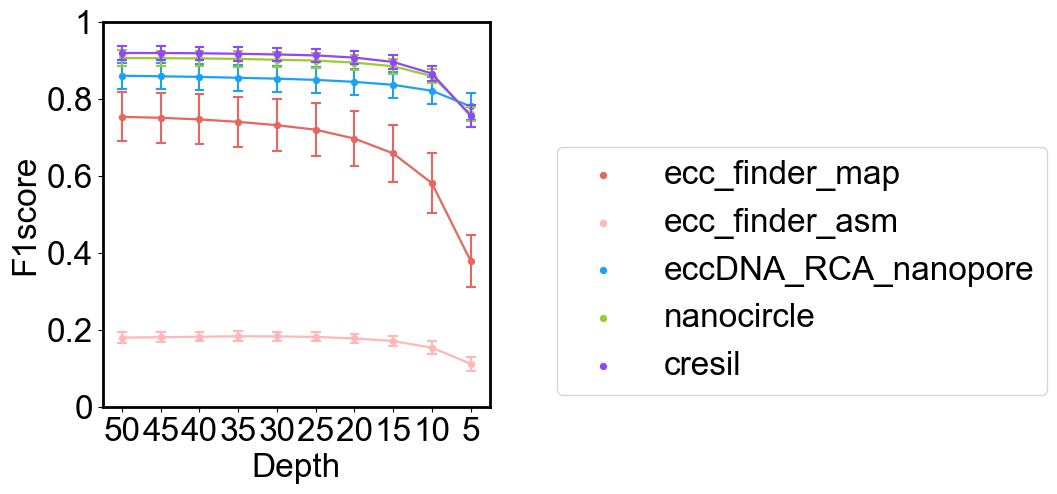

In [8]:
fig = plt.figure(figsize=(5,5))
subplot = gs.GridSpec(1, 1,hspace=0.05, wspace=0.05)
ax1 = fig.add_subplot(subplot[0, 0])
#ax2 = fig.add_subplot(subplot[1, 0])

sns.pointplot(data=total_depth_result90, 
              x='sample',
              y='F1score2',
              hue='tools',
              ax=ax1, 
              palette=palette_nanopore,
              scale=0.6,
              errwidth=1.5,
              capsize=0.2,
              errorbar='se',
              label=nanopore_labels[tool]
              )
fig.legend(loc=3,bbox_to_anchor=(1,0.1),fontsize=24)

ax1.set_xlabel('Depth');
ax1.spines[['left','top','right','bottom']].set_linewidth(2)


ax1.legend_.remove()
ax1.set_ylim(0,1);ax1.invert_xaxis()
ax1.set_xticks(range(10),[5*(i+1) for i in range(10)], fontsize=24)
ax1.set_yticks([0,.2,.4,.6,.8,1],[0,.2,.4,.6,.8,1], fontsize=24)
ax1.set_ylabel('F1score',fontsize=24)
ax1.set_xlabel('Depth',fontsize=24)
plt.savefig('/home/qukun/liuke/workspace/benchmark/Figure/figure1d_LR_depth_F1score.pdf', dpi=2000, bbox_inches='tight')

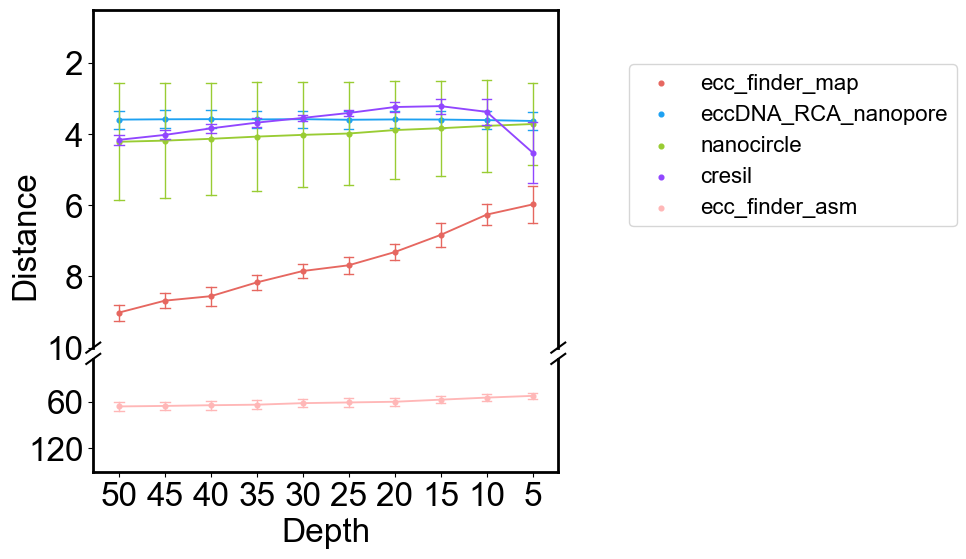

In [9]:
fig = plt.figure(figsize=(6,6))
subplot = gs.GridSpec(2, 1, height_ratios=[3, 1],hspace=0.05, wspace=0.05)
ax1 = fig.add_subplot(subplot[0, 0])
ax2 = fig.add_subplot(subplot[1, 0])

sns.pointplot(data=total_depth_result90[total_depth_result90.tools!='ecc_finder_asm'], 
              x='sample',
              y='Distance',
              hue='tools',
              ax=ax1, 
              palette=palette_nanopore,
              scale=0.5,
              errwidth=1,
              capsize=0.2,
              errorbar='se',
              label=nanopore_labels[tool]
              )

sns.pointplot(data=total_depth_result90[total_depth_result90.tools=='ecc_finder_asm'], 
              x='sample',
              y='Distance',
              hue='tools',
              ax=ax2, 
              palette=palette_nanopore,
              scale=0.5,
              errwidth=1,
              capsize=0.2,
              errorbar='se',
              label=nanopore_labels[tool]
              )

fig.legend(loc=3,bbox_to_anchor=(1,0.5),fontsize=16)

ax1.set_xlabel('');ax1.set_xticks([])
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-0.015, 0.015),(-0.015, +0.015), **kwargs)
ax1.plot((1-0.015, 1.015),(-0.015, +0.015), **kwargs)
kwargs1 = dict(transform=ax2.transAxes, color='k', clip_on=False)
ax2.plot((-0.015, 0.015),(1-0.015*3, 1+.015*3), **kwargs1)
ax2.plot((1-0.015, 1.015),(1-0.015*3, 1+.015*3), **kwargs1)
ax1.spines["bottom"].set_visible(False);
ax2.spines["top"].set_visible(False)
ax1.spines[['left','top','right']].set_linewidth(2)
ax2.spines[['left','right','bottom']].set_linewidth(2)
ax1.legend_.remove();ax2.legend_.remove()

ax1.set_ylim(0.5,5);ax1.invert_yaxis();ax1.invert_xaxis()
ax2.set_ylim(5,150);ax2.invert_yaxis();ax2.invert_xaxis()
ax1.set_yticks([2,4,6,8,10],[2,4,6,8,10],fontsize=24)
ax2.set_xticks(range(10),[5*i for i in range(1,11)], fontsize=24)
ax2.set_yticks([60,120],[60,120], fontsize=24)
ax1.set_ylabel('Distance',y=1/3,fontsize=24)
ax2.set_ylabel('');ax2.set_xlabel('Depth',fontsize=24)

plt.savefig('/home/qukun/liuke/workspace/benchmark/Figure/sfigure2b_LR_depth_distance.pdf', dpi=2000, bbox_inches='tight')

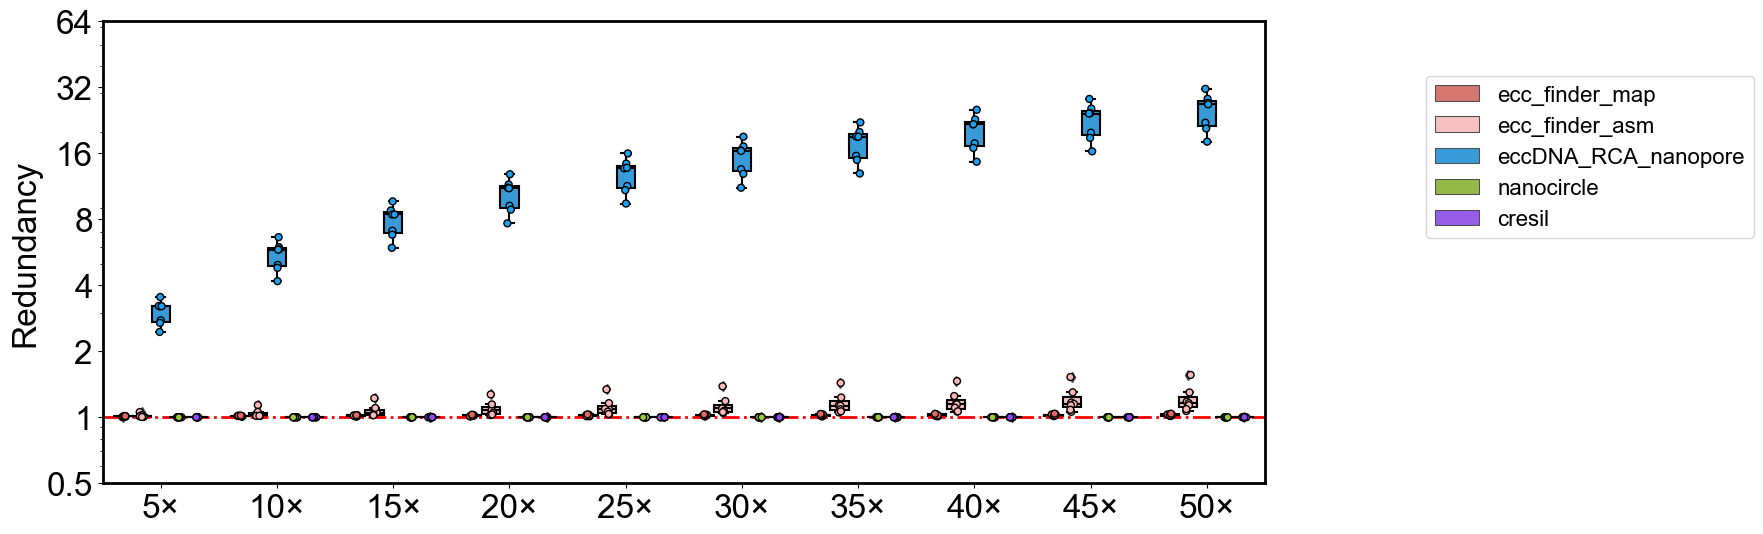

In [10]:
fig = plt.figure(figsize=(15,6))
subplot = gs.GridSpec(1, 1,hspace=0.05, wspace=0.05)
ax1 = fig.add_subplot(subplot[0, 0])
#ax2 = fig.add_subplot(subplot[1, 0])

sns.boxplot(data=total_depth_result90, 
            x='sample',
            y='Redundancy',
            hue='tools',
            ax=ax1, 
            palette=palette_nanopore,
            capprops={'color':'black'},
            whiskerprops={'color':'black'},
            medianprops={'color':'black'},
            boxprops={'edgecolor':'black'})
fig.legend(loc=3,bbox_to_anchor=(1,0.5),fontsize=16)
sns.stripplot(total_depth_result90,
              x='sample',
              y='Redundancy',
              hue='tools',
              edgecolor='black',
              linewidth=1,
              palette=palette_nanopore,
              ax=ax1,
              dodge=True,
              size=5)
plt.yscale("log") 
ax1.legend_.remove()
plt.axhline(y=1,linestyle='-.',color='r',linewidth=2)
ax1.spines[['left','top','bottom','right']].set_linewidth(2)
ax1.set_xticks(range(10),['{0}×'.format(5*(i+1)) for i in range(10)], fontsize=24)
ax1.set_yticks([.5,1,2,4,8,16,32,64],[.5,1,2,4,8,16,32,64],fontsize=24)

ax1.set_xlabel(''); ax1.set_ylabel('Redundancy',fontsize=24);
plt.savefig('/home/qukun/liuke/workspace/benchmark/Figure/figure1e_LR_redundancy.pdf', dpi=2000, bbox_inches='tight')

##### 3.3.3 Visualise robustness of Chimeric DNA proportion

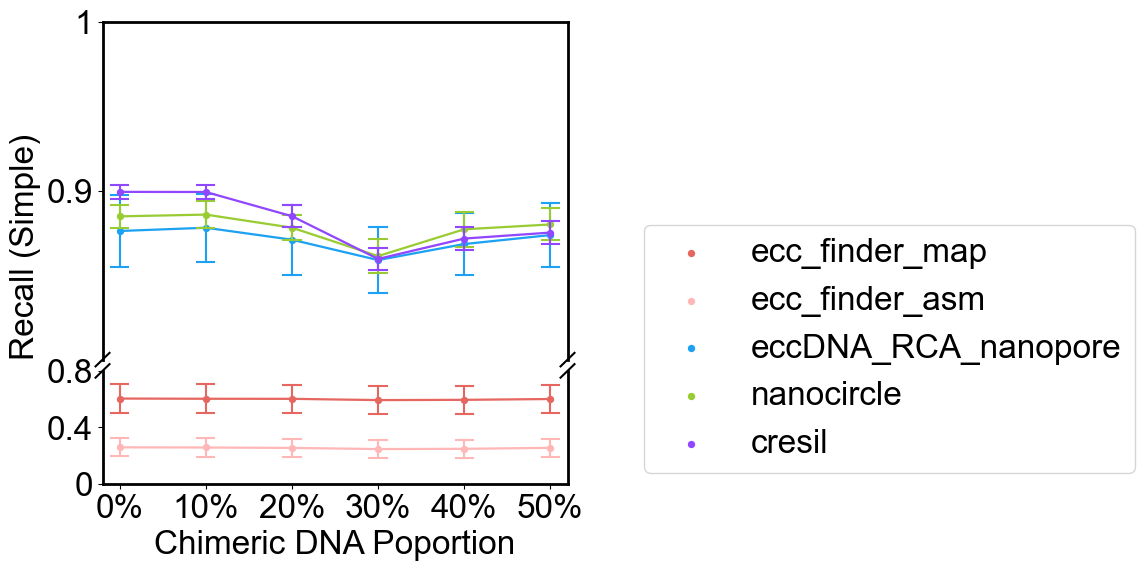

In [11]:
fig = plt.figure(figsize=(6,6))
subplot = gs.GridSpec(2, 1, height_ratios=[3, 1],hspace=0.05, wspace=0.05)
ax1 = fig.add_subplot(subplot[0, 0])
ax2 = fig.add_subplot(subplot[1, 0])

sns.pointplot(data=total_prop_result90, 
              x='sample',
              y='Recall_Simple',
              hue='tools',
              ax=ax1, 
              palette=palette_nanopore,
              scale=0.6,
              errwidth=1.5,
              capsize=0.2,
              errorbar='se',
              label=nanopore_labels[tool]
              )
fig.legend(loc=3,bbox_to_anchor=(1,0.1),fontsize=24)
sns.pointplot(data=total_prop_result90[total_prop_result90.tools.str.startswith('ecc_finder')], 
              x='sample',
              y='Recall_Simple',
              hue='tools',
              ax=ax2, 
              palette=palette_nanopore,
              scale=0.6,
              errwidth=1.5,
              capsize=0.2,
              errorbar='se',
              label=nanopore_labels[tool]
              )
ax1.set_xlabel('');ax1.set_xticks([])
ax2.set_ylabel('')
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-0.015, 0.015),(-0.015*4/3, +0.015*4/3), **kwargs)
ax1.plot((1-0.015, 1.015),(-0.015*4/3, +0.015*4/3), **kwargs)
kwargs1 = dict(transform=ax2.transAxes, color='k', clip_on=False)
ax2.plot((-0.015, 0.015),(1-0.015*4, 1+.015*4), **kwargs1)
ax2.plot((1-0.015, 1.015),(1-0.015*4, 1+.015*4), **kwargs1)
ax1.spines["bottom"].set_visible(False);ax1.spines[['left','top','right']].set_linewidth(2)
ax2.spines["top"].set_visible(False);ax2.spines[['left','bottom','right']].set_linewidth(2)

ax1.legend_.remove();ax2.legend_.remove()
ax1.set_ylim(0.8,1);
ax2.set_ylim(0,0.8);
ax1.set_xlim(-.2,5.2);
ax2.set_xlim(-.2,5.2);
ax2.set_xticks(range(6),['{0}%'.format(10*i) for i in range(6)], fontsize=24)
ax1.set_yticks([.9,1],[.9,1],fontsize=24)
ax2.set_yticks([0,.4,.8,],[0,.4,.8],fontsize=24)
ax1.set_ylabel('Recall (Simple)',y=1/3,fontsize=24)
ax2.set_xlabel('Chimeric DNA Poportion',fontsize=24);
plt.savefig('/home/qukun/liuke/workspace/benchmark/Figure/figure1f_LR_prop_recall_simple.pdf', dpi=2000, bbox_inches='tight')

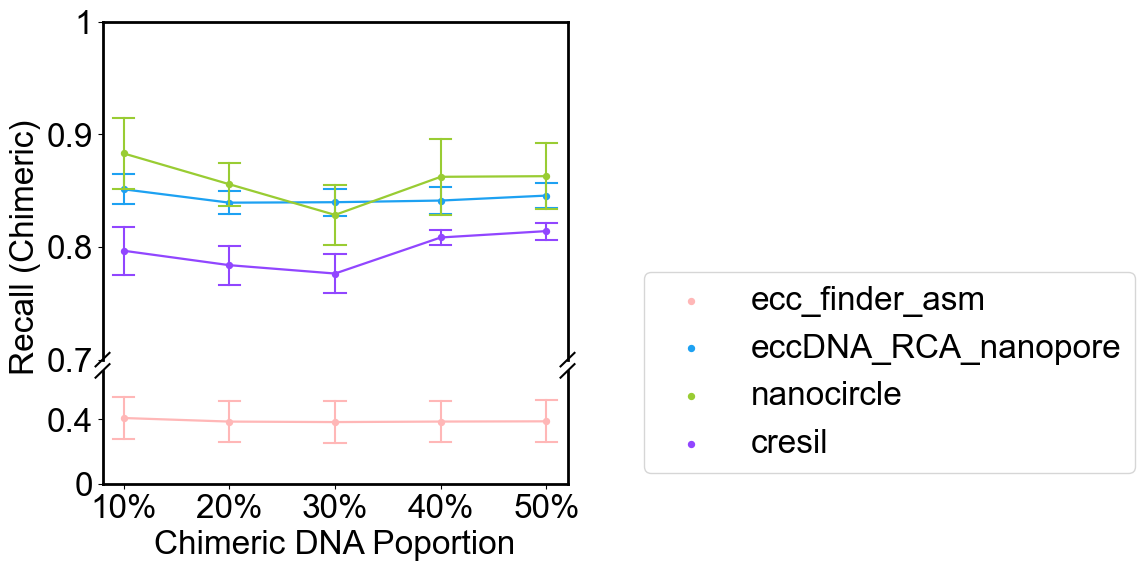

In [12]:
fig = plt.figure(figsize=(6,6))
subplot = gs.GridSpec(2, 1, height_ratios=[3, 1],hspace=0.05, wspace=0.05)
ax1 = fig.add_subplot(subplot[0, 0])
ax2 = fig.add_subplot(subplot[1, 0])

sns.pointplot(data=total_prop_result90[total_prop_result90.tools!='ecc_finder_map'], 
              x='sample',
              y='Recall_Chimeric',
              hue='tools',
              ax=ax1, 
              palette=palette_nanopore,
              scale=0.6,
              errwidth=1.5,
              capsize=0.2,
              errorbar='se',
              label=nanopore_labels[tool]
              )
fig.legend(loc=3,bbox_to_anchor=(1,0.1),fontsize=24)
sns.pointplot(data=total_prop_result90[total_prop_result90.tools=='ecc_finder_asm'], 
              x='sample',
              y='Recall_Chimeric',
              hue='tools',
              ax=ax2, 
              palette=palette_nanopore,
              scale=0.6,
              errwidth=1.5,
              capsize=0.2,
              errorbar='se',
              label=nanopore_labels[tool]
              )
ax1.set_xlabel('');ax1.set_xticks([])
ax2.set_ylabel('')
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-0.015, 0.015),(-0.015*4/3, +0.015*4/3), **kwargs)
ax1.plot((1-0.015, 1.015),(-0.015*4/3, +0.015*4/3), **kwargs)
kwargs1 = dict(transform=ax2.transAxes, color='k', clip_on=False)
ax2.plot((-0.015, 0.015),(1-0.015*4, 1+.015*4), **kwargs1)
ax2.plot((1-0.015, 1.015),(1-0.015*4, 1+.015*4), **kwargs1)
ax1.spines["bottom"].set_visible(False);ax1.spines[['left','top','right']].set_linewidth(2)
ax2.spines["top"].set_visible(False);ax2.spines[['left','bottom','right']].set_linewidth(2)

ax1.legend_.remove();ax2.legend_.remove()
ax1.set_ylim(0.7,1);
ax2.set_ylim(0,0.7);
ax1.set_xlim(.8,5.2);
ax2.set_xlim(.8,5.2);

ax2.set_xticks(range(1,6),['{0}%'.format(10*i) for i in range(1,6)], fontsize=24)
ax1.set_yticks([.7,.8,.9,1],[.7,.8,.9,1],fontsize=24)
ax2.set_yticks([0,.4,],[0,.4],fontsize=24)
ax1.set_ylabel('Recall (Chimeric)',y=1/3,fontsize=24)
ax2.set_xlabel('Chimeric DNA Poportion',fontsize=24);
plt.savefig('/home/qukun/liuke/workspace/benchmark/Figure/figure1f_LR_prop_recall_chimeric.pdf', dpi=2000, bbox_inches='tight')

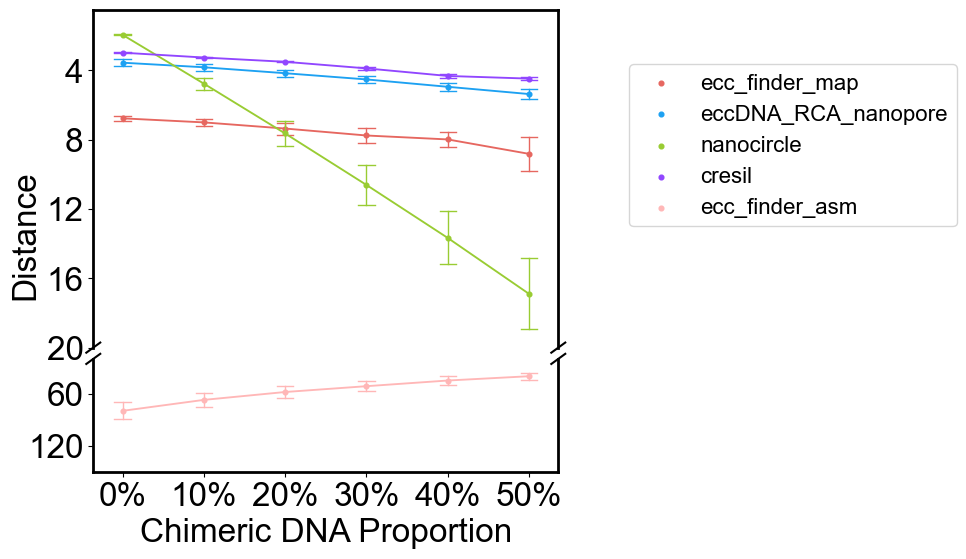

In [13]:
fig = plt.figure(figsize=(6,6))
subplot = gs.GridSpec(2, 1, height_ratios=[3, 1],hspace=0.05, wspace=0.05)
ax1 = fig.add_subplot(subplot[0, 0])
ax2 = fig.add_subplot(subplot[1, 0])

sns.pointplot(data=total_prop_result90[total_prop_result90.tools!='ecc_finder_asm'], 
              x='sample',
              y='Distance',
              hue='tools',
              ax=ax1, 
              palette=palette_nanopore,
              scale=0.5,
              errwidth=1,
              capsize=0.2,
              errorbar='se',
              label=nanopore_labels[tool]
              )

sns.pointplot(data=total_prop_result90[total_prop_result90.tools=='ecc_finder_asm'], 
              x='sample',
              y='Distance',
              hue='tools',
              ax=ax2, 
              palette=palette_nanopore,
              scale=0.5,
              errwidth=1,
              capsize=0.2,
              errorbar='se',
              label=nanopore_labels[tool]
              )
fig.legend(loc=3,bbox_to_anchor=(1,0.5),fontsize=16)

ax1.set_xlabel('');ax1.set_xticks([])
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-0.015, 0.015),(-0.015, +0.015), **kwargs)
ax1.plot((1-0.015, 1.015),(-0.015, +0.015), **kwargs)
kwargs1 = dict(transform=ax2.transAxes, color='k', clip_on=False)
ax2.plot((-0.015, 0.015),(1-0.015*3, 1+.015*3), **kwargs1)
ax2.plot((1-0.015, 1.015),(1-0.015*3, 1+.015*3), **kwargs1)
ax1.spines["bottom"].set_visible(False);
ax2.spines["top"].set_visible(False)
ax1.spines[['left','top','right']].set_linewidth(2)
ax2.spines[['left','right','bottom']].set_linewidth(2)

ax1.legend_.remove();ax2.legend_.remove()

ax1.set_ylim(0.5,20);ax1.invert_yaxis();
ax2.set_ylim(20,150);ax2.invert_yaxis();
ax1.set_yticks([4,8,12,16,20],[4,8,12,16,20],fontsize=24)
ax2.set_xticks(range(6),['%i%s'%(10*i,'%') for i in range(6)], fontsize=24)
ax2.set_yticks([60,120],[60,120], fontsize=24)
ax1.set_ylabel('Distance',y=1/3,fontsize=24)
ax2.set_ylabel('');ax2.set_xlabel('Chimeric DNA Proportion',fontsize=24)
plt.savefig('/home/qukun/liuke/workspace/benchmark/figure/sfigure2d_LR_prop_distance.pdf', dpi=2000, bbox_inches='tight')